# Neural Tangent Kernels

A few notes on the theory behind NTKs, based on  
- [Belkin et al, 2018](https://arxiv.org/abs/1812.11118)
-  [Jacot et al, 2018](http://arxiv.org/abs/1806.07572)
- [Lee et al, 2018](https://arxiv.org/abs/1711.00165)
-  [Lee et al, 2019](http://arxiv.org/abs/1902.06720)  
- [Chizat et al,2019](https://papers.nips.cc/paper/8559-on-lazy-training-in-differentiable-programming.pdf)



In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.linalg import expm 
from datetime import datetime


## Background 

- unclear why and how neural networks generalise so well
- more or less impossible to understand learning dynamics in nonlinear network  

### Bias/Variance Trade-Off in Neural networks (Belkin et al)
- bias/variance trade-off doesn't explain behaviour of neural networks:
- if increase size even beyound threshold required for convergence on training data, test error begins to drop again   

![u-shaped loss](./belkin.jpg)  

- authors introduce notion of double decent 
- motivation for study of networks in inifinte width limit 


### Infinite Width Neural Networks & Gaussian Processes  
In the infinite width limit, function specified by neural network can be understood as function drawn from a Gaussian Process.  
#### Background Reading:  
- Equivalence of infinite width random Nnets and GPs: [Neal, 1994a](https://www.cs.toronto.edu/~radford/ftp/pin.pdf)  
- Extension to Deep Nets: [Lee et al, 2018](https://arxiv.org/abs/1711.00165)    
- [my implementation of a Gaussian Process from scratch](https://github.com/TimoFlesch/NTK/blob/master/gaussian_process.ipynb)  

Intuitive Explanation: Weights and biases are gaussian random variables. The sum of all inputs into a unit (i.e. its preactivations) is thus a sum of gaussian RVs which itself is a gaussian RV (CLT).     


#### Formally speaking
If $z_i = f_{i-1}(x_{i-1},\theta)$ denotes the preactivations at layer $i$, then 
$$
z_i \sim \mathcal{GP}(m(z(x)),K(z(x),z(x')))
$$
 as width goes to infinity.  
* Parameters have zero mean, i.e. 
$$m(z) = \mathbb{E}(z(x)) = 0$$
* Covariance matrix is given by kernel $$\kappa(x,x') = \langle z(x)z(x')\rangle$$
* Can be extended to deep nets via induction  

#### Interpretation
This is very cool from historical perspective: Nnets gained popularity in the 80s but computationally too demanding. Kernel methods took over. Now, nnets again on vogue. Good to know that there is a connection.

#### Problem
This only holds for a randomly initialised network where only the readout layer is trained. Therefore, doesn't really help with understanding SGD training dynamics




## Neural Tangent Kernels 
### *Neural Tangent Kernel (Jacot et al,2018)*  
#### Goal
   
We'd like to understand the learning dynamics of a neural network. Know great deal about dynamics in linear case (thanks Andrew!), but SGD in nonlinear network very hard to study.   
The NTK is a kernel for nnets trained end-to-end with SGD. It applies to networks in the infinite width limit (or more generally where the network is close to its linear approximation) Authors demonstrated that NTK at init is good approximation for time-varying NTK  and thus dynamics can be analytically described as long as network operates in kernel regime. 

#### Gradient Flows: Derivation of NTK
Let's have a look at training dynamics under Gradient Descent. Standard Formula:    
$$
\theta_{t+1} = \theta_{t} - \eta \nabla_\theta L(\theta_t) 
$$
$$
\frac{\theta_{t+1}-\theta{t}}{\eta} = -\nabla_\theta L(\theta_t)
$$
We assume an L2 loss:
$$
L(\theta) = \frac{1}{2}||y(\theta,x)-\hat{y}||
$$
If we assume an infinitesimally small learning rate $\eta$, we can interpret this as differential equation that tracks the change of the parameter vectors over time (**Gradient Flow**):
$$ 
\frac{d\theta(t)}{dt} = \dot{\theta} = -\nabla_\theta L(\theta_t) 
$$
$$
 \dot{\theta} = -\nabla_\theta y(\theta)(y(\theta)-\hat{y})
$$
Now here comes the cool part: We're dealing with a neural network, so the chain rule of calculus applies! This means that we can derive the dynamics of the model outputs (i.e. dynamics in function space) induced by the dynamics of the weights very easily:
$$
\dot{y(\theta)} = \nabla_\theta y(\theta)^T\dot{\theta} 
$$
$$
= -\nabla_\theta y(\theta)^T\nabla_\theta y(\theta)(y(\theta)-\hat{y})
$$
Now, we assume that the gradient of the network function acts as a feature map $\phi(x)$, which implies that its dot product over all the data points is a valid kernel, the Neural Tangent Kernel (NTK):
$$ 
H(t) = \kappa_{NTK}(x,x') =  \langle -\nabla_\theta y(\theta(t),x)^T\nabla_\theta y(\theta(t),x) \rangle, \forall x,x' \in \mathbb{R}^d 
$$

#### Lazy Learning: NTK and the Infinite Width Limit
In the infinite width limit, we make an interesting observation: Weights change only very little during training, i.e. stay close to their random initialisation:
$$
\frac{||\theta(t)-\theta(0)||_2}{||\theta(0)||_2} \approx 0
$$ 
And hence, the kernel barely varies during training:
$$
\kappa_t(x,x') \approx \kappa_{t}(x,x'), \forall t 
$$ 
Let's come up with an intuitive explanation of this phenomenon: With infinitely many weights, very small changes lead to a big **net change** in the preactivations (i.e. linearity) of a hidden layer neuron. In contrast, with only very few weights, these have to change substantially to yield the same effect.  
Moreover, Jacot has shown that the kernel at initialisation, which depends on a random variable (weights drawn from iid gaussian) converges in probability to a deterministic value in the large weight limit, i.e. 
$$
\kappa_0(x,x') \approx \kappa_{NTK}(x,x')
$$
So now we know that the time-varying kernel is essentially identical to the NTK. Importantly, the network trained to convergence is equivalent to the kernel regression solution with an NTK
$$
f_{SGD}(x,\theta) \approx f_{NTK}(x,\theta) = \kappa_{NTK}(x,X)^T \kappa_{NTK}(X,X)^{-1}y
$$
where $X$ corresponds to the dataset s.t. $\kappa_{NTK}(x,X) = [\kappa_{NTK}(x,x_1),...,\kappa_{NTK}(x,x_n)]^T$


#### Linear Approximation of Infinite Width Network (Lee et al,2019)  
At this point, it's still not clear to me how to study the dynamics of the network. However, we know that - in the NTK regime - the network parameters barely change during learning. Insight: We can just apply a 1st-order Taylor expansion (hence a linear approximation) to the network function w.r.t. its parameters around its initialisation. Now, the non-linear network is a linear function of the weights, yet still non-linear in its inputs:
$$
f(x,\theta) \approx f(x,\theta_0) + \nabla_\theta f(x,\theta_0)^T(\theta-\theta_0)
$$
And here comes the connection to NTKs: We can understand this as a linear function of x with a non-linear basis function (feature map) of the inputs, which is simply the gradient on the weights:
$$
\phi(x) = \nabla_\theta f(x,\theta_0)
$$
so the function becomes: 
$$
f(x,\theta) \approx f(x,\theta_0) + \phi(x)^T(\theta-\theta_0)
$$
This feature map can be understood as a kernel on the inputs, for which we know its form:
$$
\kappa(x,x') = \phi(x)^T\phi(x') = \nabla_\theta f(x,\theta_0)^T \nabla_\theta f(x,\theta_0)
$$

Now, the training dynamics are tractable, as we have a linear function of the weights.
Todo: brush up my understanding of dual view and the kernel trick (https://alliance.seas.upenn.edu/~cis520/dynamic/2017/wiki/index.php?n=Lectures.Kernels#toc5) 

#### Analytic Solution to the training dynamics 
So far, I have understood that the training dynamics can be described by a gradient flow. The expression for this contains the NTK. However, the NTK itself is still dependent on t, i.e. a time-varying process. From the theory of infinite width networks, we known that weights of infinitely wide networks barely change during training (see my intuitive explanation above) and that the network can be approximated by its linearisation. Hence, when in the kernel regime (i.e. barely changing Jacobian, i.e. close to its linearisation) the time-varying kernel of the neural network can be approximated by the kernel at initialisation 
$$
\nabla y(\theta(t)) \approx \nabla y(\theta_0)
$$ 
$$
H(\theta(t)) \approx H(\theta_0)
$$

This is very good news, as we can update our expression for the gradient flow, which used to be:
$$
\dot{y(\theta)} = \nabla_\theta y(\theta)^T\dot{\theta} = H(\theta(t)) y(\theta)-\hat{y})
$$
Now, it becomes  
$$
\dot{y(\theta)} = \nabla_\theta y(\theta)^T\dot{\theta} = H(\theta_0) y(\theta)-\hat{y})
$$
**The equilibrium for this equation is achieved when the training loss is zero.**
Let's simplify this expression with a substitution of variables
$$ 
u = y(\theta)-\hat{y}
$$ 
Now the ODE becomes 
$$ 
 \dot{u} = -H(\theta_0)u 
$$ 
Ok, cool. A system of differential equations can be solved with the matrix exponential. So let's derive the output (recall: difference between output and predictions to be precise) at time t 
$$ 
y(\theta(t))-\hat{y} = u(t) = u(0)e^{-H(\theta_0)t}
$$ 
Awesome, we're now able to track the learning dynamics of a neural network using the NTK at initialisation! And we have shown that the SGD converges to zero training loss as long as the non-linear model is close to its linearisation (i.e. in the infinite weight limit)




## Lazy Learning and NTK Regime on standard Neural Networks (chizat et al, 2019)

All above is pretty cool, but only holds in the infinite width limit. I understand intuitively why. With many weights, each contributes a little, thus ensemble has large impact on output, thus no need for dramatic changes (highly distributed code).
But in reality, width is obs. finite. How to apply these findings to real nnets?
**Chizat et al argue that a finite-width network can be pushed into the NTK regime by chosing an appropriate explicit scaling factor.**They demonstrate that any parametric model (not only nnets) can be trained in lazy regime if its outputs are close to zero after random initialisation. 
If I understand correctly, this can be achieved with LeCun initialisation (variance scales with network width)

# A practical example
Let's consider a practical example. 
We're going to use a simple MLP to solve the XOR-Problem and use an NTK to derive the learning dynamics. We'll investigate how initialisation schemes and network width determine whether or not the network operates in the kernel regime

## Problem Formulation
Given two binary variables, the network should return 1 if one of them is set to 1 and 0 otherwise.  
<table border='1px'>
<tr>
    <th>A </th>
    <th>B </th>
    <th>A xor B </th>
</tr>
<tr>
    <td> true </td>
    <td> true </td>
    <td> false </td>
</tr>
<tr>
    <td> false </td>
    <td> true </td>
    <td> true </td>
</tr>
<tr>
    <td> true </td>
    <td> false </td>
    <td> true </td>
</tr>
<tr>
    <td> false </td>
    <td> false </td>
    <td> false </td>
</tr>

</table>

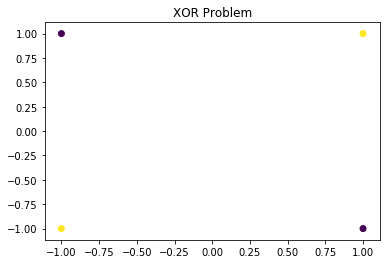

In [2]:
# generate data 
x = np.asarray([[1,1,-1,-1],[1,-1,1,-1]])
y = np.array([1,-1,-1,1])
plt.figure()
plt.scatter(x[0,:],x[1,:],c=y)
plt.title('XOR Problem')
y = y[np.newaxis,:]


## SGD Solution
Let's first train a neural network with standard SGD. The network consists of an input layer (n=2), a hidden layer with relu nonlinearity (n=X) and an output layer (n=1). We'll use L2 loss on the network's predictions.   
### Network Architecture

#### Dimensionalities
$$ 
x \in \mathbb{R}^2, 
h \in \mathbb{R}^n,  
y \in \mathbb{R}^1
$$ 

#### Forward Pass
$$ 
h_{in} = xw_{hx} \\
h_{out} = max(0,h_{in}) \\
\hat{y} = h_{out}w_{yh} \\
L = \frac{1}{2}(\hat{y}-y)^{2}
$$ 

#### Partial Derivatives
$$
\frac{\partial L}{\partial \hat{y}} = (\hat{y}-y)
$$ 
$$ 
\frac{\partial \hat{y}}{\partial h_{out}} = w_{yh}
$$ 
$$ 
\frac{\partial \hat{y}}{\partial w_{yh}} = h_{out}
$$ 
$$ 
\frac{\partial h_{out}}{\partial h_{in}} = \mathbf{1}_{(h_{in}>0)} h_{in}
$$ 
$$
\frac{\partial h_{in}}{\partial x} = w_{hx}
$$
$$
\frac{\partial h_{in}}{\partial w_{hx}} = x
$$

#### Backward Pass 
$$
\Delta w_{yh} = \nabla L_{w_{yh}} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w_{yh}}
$$
$$
\Delta w_{yh} = (\hat{y}-y)h_{out}
$$
$$ 
\Delta w_{hx} = \nabla L_{w_{hx}} = \frac{\partial L}{\partial \hat{y}}  \frac{\partial \hat{y}}{\partial h_{out}} \odot \frac{\partial h_{out}}{\partial h_{in}}  \frac{\partial h_{in}}{\partial w_{hx}}
$$
$$
\Delta w_{hx} =  (\hat{y}-y)w_{yh}\odot (\mathbf{1}_{(h_{in}>0)} h_{in}) x
$$ 

#### Weight Updates

$$
w_{yh} = w_yh - \eta\Delta w_{yh}
$$
$$
w_{hx} = w_hx - \eta\Delta w_{hx}
$$

In [3]:
from numpy.linalg import norm
# define a couple of helper functions
def relu(x):
    return x*(x>0)
def deriv_relu(x):
    return (x>0).astype('double')

def loss(y_,y):
    return .5*np.linalg.norm(y_-y,2)**2
def deriv_loss(y_,y): 
    return (y_-y)

def compute_relchange(w0,wt):    
    return (norm(wt.flatten())-norm(w0.flatten()))/norm(w0.flatten())

In [6]:
# network trainer
def run_simulation(x,y,n_hidden=500,scale_w1=1/np.sqrt(2),scale_w2=1/500):
    #randomly initialise weights 
    w_hx = scale_w1*np.random.randn(n_hidden,n_in)
    w_yh = scale_w2*np.random.randn(n_out,n_hidden)
    # store init weights
    w_hx_0 = w_hx 
    w_yh_0 = w_yh
    w_relchange1 = []
    w_relchange2 = []
    losses = []


    # whole-dataset GD with several episodes
    for jj in range(n_iter):
        # forward pass 
        h_in = w_hx.dot(x)
        h_out = relu(h_in)
        y_ = w_yh.dot(h_out)
        l = loss(y,y_)
        # partial derivatives
        dl_dy = deriv_loss(y_,y)
        dy_dh = w_yh 
        dy_dw = h_out
        dho_dhi = deriv_relu(h_in)
        dhi_dw = x
        # backward pass:
        delta_dwyh = dl_dy.dot(dy_dw.T)
        delta_dwhx = (dl_dy.T.dot(dy_dh)*dho_dhi.T).T.dot(dhi_dw.T)
        
        # weight updates 
        w_yh = w_yh - lrate*delta_dwyh 
        w_hx = w_hx - lrate*delta_dwhx

        # store relative weight change
        w_relchange1.append(compute_relchange(w_hx_0,w_hx))
        w_relchange2.append(compute_relchange(w_yh_0,w_yh))
        # store loss
        losses.append(l)
    return losses,w_relchange1,w_relchange2

### Impact of Network Width on relative weight change during training

26/05/2020 15:37:37 - network 1/4
26/05/2020 15:37:47 - network 2/4
26/05/2020 15:37:56 - network 3/4
26/05/2020 15:38:11 - network 4/4
done


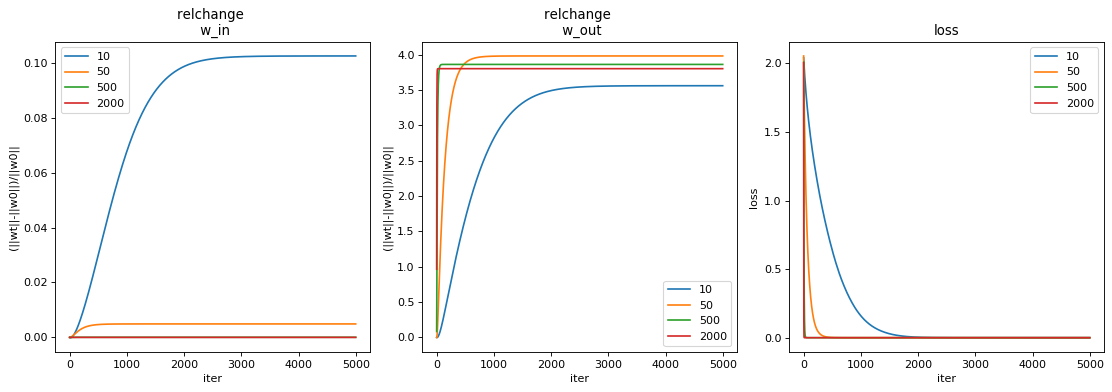

In [40]:
# define network parameters 
n_in = 2
n_out = 1
n_hidden_all = [5,10,50,500,2000]
n_runs = 20
n_iter = 5000
lrate = 1e-3

# train network with sgd 
all_losses = np.empty((len(n_hidden_all),n_runs,n_iter))
w_relchange1 = np.empty((len(n_hidden_all),n_runs,n_iter))
w_relchange2 = np.empty((len(n_hidden_all),n_runs,n_iter))
for ii, n in enumerate(n_hidden_all):
    print(datetime.now().strftime("%d/%m/%Y %H:%M:%S") + ' - network ' + str(ii+1) + '/' + str(len(n_hidden_all)))
    for jj in range(n_runs):
        all_losses[ii,jj,:],w_relchange1[ii,jj,:],w_relchange2[ii,jj,:] = run_simulation(x,y,n_hidden=n,scale_w1=1/np.sqrt(2),scale_w2=1/n)
print("done")


fig=plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')
lines = []
for ii in range(len(n_hidden_all)):
    plt.subplot(1,3,1)
    plt.plot(np.mean(w_relchange1[ii,:,:],0))
    plt.title('relchange \n w_in')
    plt.xlabel('iter')
    plt.ylabel('(||wt||-||w0||)/||w0||')

    plt.subplot(1,3,2)
    plt.plot(np.mean(w_relchange2[ii,:,:],0))
    plt.title('relchange \n w_out')
    plt.xlabel('iter')
    plt.ylabel('(||wt||-||w0||)/||w0||')

    plt.subplot(1,3,3)
    line, = plt.plot(np.mean(all_losses[ii,:,:],0))
    lines.append(line)
    plt.title('loss')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.tight_layout()
for ii in range(1,4):
    plt.subplot(1,3,ii)
    plt.legend(lines,n_hidden_all)

While the relative change of readout weights during training doesn't appear to depend heavily on the network width, we observe significant differences for the input weights. More specifically, unless the network has only very few hidden units, the input weights seem to stay very close to initialisation. Importantly, all networks were trained to convergence, indicating that even "lazy" networks are able to solve the task. 

### Impact of scaling of initial weights on relative weight change during training (w_in only)
The previous findings made me wonder whether even very wide networks could be pushed out of the lazy training regime. To investigate this, I performed the same simulation but varied the magnitude by which the weights were scaled at initialisation. I expected that very small network weights would have to adapt substantially during training, whereas with large but randomly initialised weights, the net should operate in the kernel regime. The latter would make sense as any arbitrary mapping into a high-dimensional feature space should very likely be sufficient to solve a non-linear problem with a linear readout (see Cover's theorem)

26/05/2020 15:53:46 - network 1/4
26/05/2020 15:54:05 - network 2/4
26/05/2020 15:54:24 - network 3/4
26/05/2020 15:54:43 - network 4/4
done


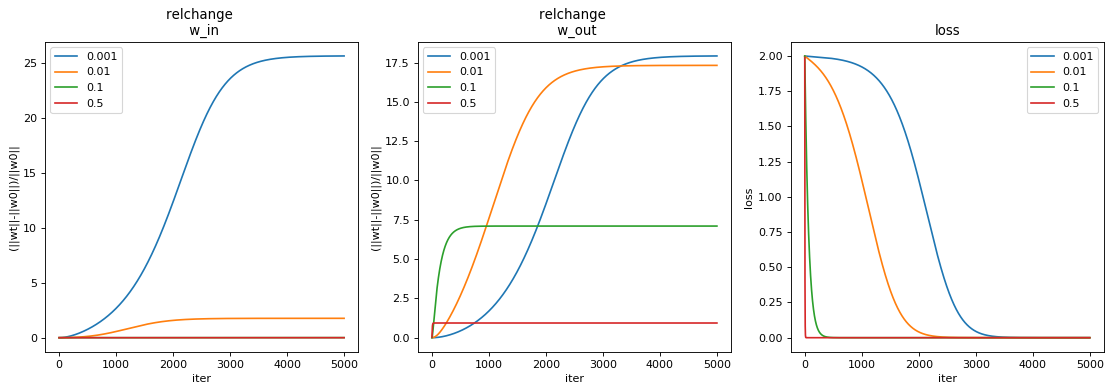

In [53]:
# define network parameters 
n_in = 2
n_out = 1
n_hidden = 500
w1_init = [0.001,0.01,0.1,0.5]
w2_init = np.repeat(1/n_hidden,len(w1_init))
n_runs = 20
n_iter = 5000
lrate = 1e-3

# train network with sgd 
all_losses = np.empty((len(w1_init),n_runs,n_iter))
w_relchange1 = np.empty((len(w1_init),n_runs,n_iter))
w_relchange2 = np.empty((len(w1_init),n_runs,n_iter))
for ii, initval in enumerate(w1_init):
    print(datetime.now().strftime("%d/%m/%Y %H:%M:%S") + ' - network ' + str(ii+1) + '/' + str(len(w1_init)))
    for jj in range(n_runs):
        all_losses[ii,jj,:],w_relchange1[ii,jj,:],w_relchange2[ii,jj,:] = run_simulation(x,y,n_hidden=n,scale_w1=initval,scale_w2=1/n_hidden)
print("done")


fig=plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')
lines = []
for ii in range(len(w1_init)):
    plt.subplot(1,3,1)
    plt.plot(np.mean(w_relchange1[ii,:,:],0))
    plt.title('relchange \n w_in')
    plt.xlabel('iter')
    plt.ylabel('(||wt||-||w0||)/||w0||')

    plt.subplot(1,3,2)
    plt.plot(np.mean(w_relchange2[ii,:,:],0))
    plt.title('relchange \n w_out')
    plt.xlabel('iter')
    plt.ylabel('(||wt||-||w0||)/||w0||')

    plt.subplot(1,3,3)
    line, = plt.plot(np.mean(all_losses[ii,:,:],0))
    lines.append(line)
    plt.title('loss')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.tight_layout()
for ii in range(1,4):
    plt.subplot(1,3,ii)
    plt.legend(lines,w1_init)

As expected, all networks converged and were able to solve the XOR problem, but the relative change of network parameters depended heavily on the initial scaling of the input weights. Importantly, with very small intial input weights, both the input and readout weights changed substantially during training. In contrast, a large scaling factor ensured that the input weights remained close to intialisation (i.e. network operated in lazy learning regime), and so did the readout weights (even though to a mucm lesser extent)

## NTK Solution
Let's have a look at the learning dynamics derived from an NTK   
Remember that the NTK is defined as follows 
$$ 
H(t) = \kappa_{NTK}(x,x') =  \langle -\nabla_\theta y(\theta(t),x)^T\nabla_\theta y(\theta(t),x) \rangle, \forall x,x' \in \mathbb{R}^d 
$$
Here, the gradient is applied to the *network function*, i.e. the whole neural network.
Also, remember that we can study the network dynamics by solving the differential equation of the gradient flow 
$$ 
y(\theta(t))-\hat{y} = u(t) = u(0)e^{-H(\theta_0)t}
$$ 
For this, we only need to evaluate the NTK at initialisation (neat!).  
Let's jump straight to the implementation

we begin with collecting the partial derivatives and setting up the gradient of the network function. We just need to stack the individual gradients - for input and readout weihts - on top of each other.